# Outlierit

Lukee väliaikaisesti kansiosta datan, yhdistää .csv tiedostot yhteen pandasin dataframeen

In [1]:
import pandas as pd
import glob
path = r'./data' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)
df

,node_id,timestamp,x,y,z,q
0,-2393099149039893833,2020-06-24 12:20:08.533016+00:00,2762,-257,100,0
1,-2393099149039893833,2020-06-24 12:20:08.620015+00:00,2870,-344,100,0
2,-2393099149039893833,2020-06-24 12:20:09.622827+00:00,2916,-344,100,0
3,-2393099149039893833,2020-06-24 12:20:09.622846+00:00,2894,-254,100,0
4,-2393099149039893833,2020-06-24 12:20:10.116102+00:00,2888,-188,100,0
...,...,...,...,...,...,...
13890901,4996252679627069957,2020-06-01 03:00:05.469336+00:00,635,1064,0,0
13890902,4996252679627069957,2020-06-01 03:00:06.47926+00:00,681,760,0,0
13890903,4996252679627069957,2020-06-01 03:00:08.507118+00:00,622,991,0,0
13890904,4996252679627069957,2020-06-01 03:00:09.547553+00:00,644,1066,0,0


Tarkistetaan onko outouksia

In [30]:
missing_count = df.isnull().sum()
print(missing_count)

node_id      0
timestamp    0
x            0
y            0
z            0
q            0
dtype: int64


In [89]:
print("uniques in x",len(df['x'].unique()))
print("uniques in y",len(df['y'].unique()))
print("uniques in z",len(df['z'].unique()))
print("uniques in q",len(df['q'].unique()))

uniques in x 10532
uniques in y 7899
uniques in z 3
uniques in q 1


In [90]:
print("uniques in z",df['z'].unique())
print("uniques in q",df['q'].unique())

uniques in z [100 400   0]
uniques in q [0]


- q eli signaalin laatu ei vaihtele yhtään.
- z eli z-akseli (ylös päin), muuttuu nollasta sataan ja neljäänsataan

In [ ]:
from scipy.stats import zscore
import numpy as np
z = np.abs(zscore(df))
print(z)

### Otetaan käyttöön vain ensimmäinen node

In [10]:
print("Number of nodes: %s" % len(df["node_id"].unique()))

print("First node: %s" % df["node_id"].unique()[0])
node = df["node_id"].unique()[0]

df1 = df[df["node_id"] == node]
df1

Number of nodes: 32
First node: -2393099149039893833


,node_id,timestamp,x,y,z,q
0,-2393099149039893833,2020-06-24 12:20:08.533016+00:00,2762,-257,100,0
1,-2393099149039893833,2020-06-24 12:20:08.620015+00:00,2870,-344,100,0
2,-2393099149039893833,2020-06-24 12:20:09.622827+00:00,2916,-344,100,0
3,-2393099149039893833,2020-06-24 12:20:09.622846+00:00,2894,-254,100,0
4,-2393099149039893833,2020-06-24 12:20:10.116102+00:00,2888,-188,100,0
...,...,...,...,...,...,...
583869,-2393099149039893833,2020-10-23 06:57:02.988595+00:00,2766,-339,100,0
583870,-2393099149039893833,2020-10-23 06:57:21.988764+00:00,2772,-354,100,0
583871,-2393099149039893833,2020-10-23 06:57:31.988804+00:00,2776,-370,100,0
583872,-2393099149039893833,2020-10-23 06:57:41.988742+00:00,2775,-363,100,0


In [23]:
print("x",len(df1["x"].unique()))
print("y",len(df1["y"].unique()))
print("z",len(df1["z"].unique()))
print("q",len(df1["q"].unique()))

x 5055
y 4514
z 1
q 1


In [24]:
from scipy.stats import zscore
import numpy as np
print("x",np.abs(zscore(df1['x'])))
print("y",np.abs(zscore(df1['y'])))

x [0.85353784 0.97500092 1.0267352  ... 0.86928305 0.86815839 0.86590908]
y [0.73952553 0.82100207 0.82100207 ... 0.84535137 0.83879579 0.84441486]


In [75]:
df2 = df1[["x","y"]]
df2.head()

,x,y
0,2762,-257
1,2870,-344
2,2916,-344
3,2894,-254
4,2888,-188


### Poista kaikki rivit, joilla on poikkeavuuksia vähintään yhdessä sarakkeessa

- Jokaiselle sarakkeelle se laskee ensin sarakkeen jokaisen arvon Z-pistemäärän suhteessa sarakkeen keskiarvoon ja keskihajontaan.
- Sitten on Z-pisteiden absoluuttinen arvo, koska suunta ei ole väliä, vain jos se on kynnyksen alapuolella.
- kaikki (akseli = 1) varmistaa, että jokainen rivi, kaikki sarakkeet täyttävät rajoituksen.
- Lopuksi tämän ehdon tulosta käytetään datakehyksen indeksointiin.

In [125]:
from scipy.stats import zscore
import numpy as np
#np.abs(zscore(df1['x']))
df_clean = df2[(np.abs(zscore(df2)) <= 2.5).all(axis=1)]
#Pidä vain ne rivit, jotka ovat +3 - -3 keskihajonnan sisällä.

# pd.concat lisää kaksi DataFrame-kehystä yhteen liittämällä ne peräkkäin.
# jos on päällekkäisyyksiä, se kaapataan drop_duplicates:illa
# drop_duplicates oletusarvoisesti jättää ensimmäisen havainnon ja poistaa kaikki muut havainnot.
# Tässä tapauksessa haluamme, että jokainen kaksoiskappale poistetaan. Siksi keep = False -parametri
potato = pd.concat([df2, df_clean, df_clean]).drop_duplicates(keep=False)

print("Data with outliers: ", len(df2))
print("Ouliers removed:    ", len(df2) - len(potato))
print("Amount of outliers: ",  len(potato))
potato

Data with outliers:  583874
Ouliers removed:     580111
Amount of outliers:  3763


,x,y
66,-246,2581
67,-1498,5255
68,390,3496
434,1398,3276
440,774,3225
...,...,...
581191,-717,1765
581611,-249,2467
581632,-281,2470
581633,-225,2457


Huom. toistuvaan df2:een. Vain yhden df2: n avulla mitä tahansa riviä df2: ssa, joka ei ole df1, ei pidetä kaksoiskappaleena ja se säilyy. Tämä ratkaisu, jossa on vain yksi df2, toimii vain, kun df2 on df1: n osajoukko. Jos kuitenkin liitämme df2: n kahdesti, se on taattu kopio ja se poistetaan myöhemmin.

#### Toinen ratkaisu

In [120]:
df_clean = df2[np.abs(df2-df2.mean()) <= (2*df2.std())]
#Pidä vain ne rivit, jotka ovat +3 - -3 keskihajonnan sisällä.

# Sama, mutta toisinpäin
#df2[~(np.abs(df2-df2.mean()) > (3*df2.std()))]

## Plottaus

<function matplotlib.pyplot.show(close=None, block=None)>

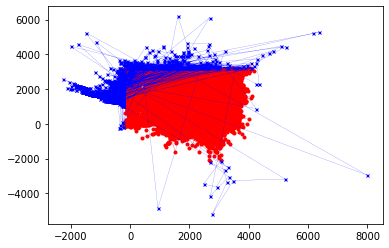

In [126]:
import matplotlib.pyplot as plt

plt.plot(df_clean["x"], df_clean["y"], color="red", marker='o', linestyle='dashed', linewidth=0.2, markersize=3)
plt.plot(potato["x"], potato["y"], color="blue", marker='x', linestyle='dashed', linewidth=0.2, markersize=3)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

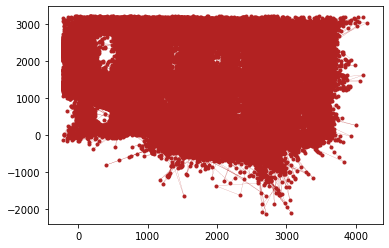

In [132]:
plt.plot(df_clean["x"], df_clean["y"], color="firebrick", marker='o', linestyle='dashed', linewidth=0.2, markersize=3)
plt.show

In [ ]:
test = df2[(np.abs(zscore(df2)) <= 3).all(axis=1)]
#Pidä vain ne rivit, jotka ovat +3 - -3 keskihajonnan sisällä.

# pd.concat lisää kaksi DataFrame-kehystä yhteen liittämällä ne peräkkäin.
# jos on päällekkäisyyksiä, se kaapataan drop_duplicates:illa
# drop_duplicates oletusarvoisesti jättää ensimmäisen havainnon ja poistaa kaikki muut havainnot.
# Tässä tapauksessa haluamme, että jokainen kaksoiskappale poistetaan. Siksi keep = False -parametri
potato = pd.concat([df2, test, test]).drop_duplicates(keep=False)

print("Data with outliers: ", len(df2))
print("Ouliers removed:    ", len(df2) - len(potato))
print("Amount of outliers: ",  len(potato))
potato

---